In [1]:
import numpy as np

In [6]:

def make_contreras_snail(label="snail", 
                         b = .1, d = 4, z = 1, a = 5, phi = 0, psi = 0, 
                         c_depth=0.1, c_n = 70, n_depth = 0, n = 0, 
                         time = 20, n_points_time = 1000, 
                         n_points_aperture=100):

    # snail axes are [XYZ][Time][Aperture Angle Theta]

    _lambda: np.array = np.zeros((3, n_points_time, n_points_aperture))
    gamma: np.array = np.zeros((3, n_points_time, n_points_aperture))
    C: np.array = np.zeros((3, n_points_time, n_points_aperture))

    # vector of points in time reshaped for broadcasting
    t: np.array = np.linspace(0, time, n_points_time).reshape((n_points_time, 1))
    theta: np.array = np.linspace(0, 2*np.pi, n_points_aperture).reshape((1, n_points_aperture))

    # precalculating some repeated operations for efficiency
    sin_t = np.sin(t)
    cos_t = np.cos(t)
    sin_theta = np.sin(theta)
    cos_theta = np.cos(theta)
    bsq = b**2
    dsq = d**2

    # shape = (3, n_points_time, 1) -> [xyz][time][constant with respect to the angle theta along the aperture]
    gamma = np.exp(b*t)*np.array([
        d*sin_t, d*cos_t, 
        np.full(n_points_time, z).reshape(n_points_time, 1)
    ])

    # Defining the normal and binormal vectors along the frennet frame for all time points and angles about the aperture
    # 3 x n_points_time x 1 for both
    N: np.array = np.array([
        b*cos_t - sin_t,
        -b*sin_t - cos_t,
        np.zeros((n_points_time, 1))
    ])/np.sqrt(b**2 + 1)

    B: np.array = np.array([
        b*z*(b*sin_t + cos_t),
        b*z*(b*cos_t - sin_t),
        np.full((n_points_time, 1), d*(bsq + 1))
    ])/np.sqrt(
        (bsq + 1)*((bsq + 1)*dsq + bsq*(z**2))
    )

    # Define the rotation matrix for the aperture given that psi 
    # is the rotation angle about the B axis in the local frennet frame
    R: np.array = np.array([
        [np.cos(psi), -np.sin(psi), 0],
        [np.sin(psi), np.cos(psi), 0],
        [0, 0, 1]
    ])
    
    # Define the unrotated and unscaled generating curve
    # Shape = (1, 1, n_points_aperture) | constant for [xyz][time], [changes for the angle]
    GC: np.array = (a*sin_theta*np.sin(phi) - cos_theta*np.cos(phi)).reshape(1, 1, n_points_aperture)*B + (a*sin_theta*np.cos(phi) + cos_theta*np.sin(phi)).reshape(1, 1, n_points_aperture)*N 
     

    # einsum lets me broadcast the rotation matrix multiplication over the time points and the aperture angles
    rGC = np.einsum('ij,jkl->ikl', R, GC)
    timescale = (1 + c_depth*np.sin(c_n*t))*np.exp(b*t) - (1 / (t + 1))

    return {"mesh" : gamma + (timescale * rGC),
            "times" : t,
            "angles" : theta,
            "timescale": timescale,
            "Beta": B
            }

In [7]:
snail = make_contreras_snail(z = 1, a = .5, n=30, d=1, 
                             n_depth=.1, phi=1, psi=0, 
                             n_points_time=1000, 
                             n_points_aperture=100)
snail["mesh"].shape

(3, 1000, 100)

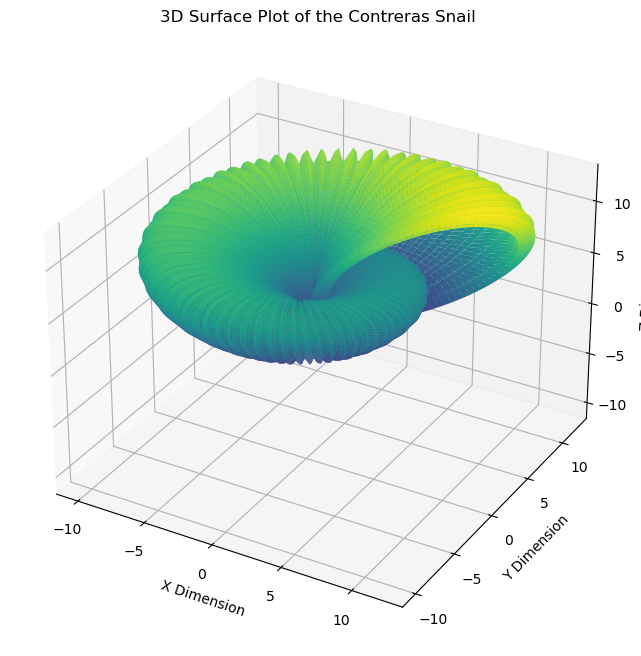

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming snail dictionary has already been defined
mesh = snail["mesh"]
times = snail["times"].flatten()
angles = snail["angles"].flatten()

# Extract X, Y, Z from the mesh
X, Y, Z = mesh[0], mesh[1], mesh[2]

# Creating a 3D plot of the snail mesh
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the 3D surface of the snail
ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')

# Setting labels and title
ax.set_xlabel('X Dimension')
ax.set_ylabel('Y Dimension')
ax.set_zlabel('Z Dimension')
ax.set_title('3D Surface Plot of the Contreras Snail')

# Ensuring all axes have the same range
all_data = np.concatenate([X.flatten(), Y.flatten(), Z.flatten()])
min_range = all_data.min()
max_range = all_data.max()

# Setting the limits for all axes to be the same
ax.set_xlim(min_range, max_range)
ax.set_ylim(min_range, max_range)
ax.set_zlim(min_range, max_range)

# Showing the plot
plt.show()


In [7]:
snail = make_contreras_snail(z = 1)


# Extract mesh data
mesh = snail["mesh"]
X, Y, Z = mesh[0], mesh[1], mesh[2]

# Create the vertices list from the mesh data
vertices = [(X[i, j], Y[i, j], Z[i, j]) for i in range(X.shape[0]) for j in range(X.shape[1])]

# Create the faces list, connecting adjacent time points and aperture angles
faces = []
n_points_time = X.shape[0]
n_points_aperture = X.shape[1]

for i in range(n_points_time - 1):
    for j in range(n_points_aperture):
        next_j = (j + 1) % n_points_aperture  # Wrap around the aperture angle
        # Define a quad face between four adjacent points
        faces.append([
            i * n_points_aperture + j,
            i * n_points_aperture + next_j,
            (i + 1) * n_points_aperture + next_j,
            (i + 1) * n_points_aperture + j
        ])

# Create a new mesh and object in Blender
mesh_data = bpy.data.meshes.new("contreras_snail_mesh")
mesh_data.from_pydata(vertices, [], faces)
mesh_data.update()

# Create an object with the mesh data
obj = bpy.data.objects.new("ContrerasSnail", mesh_data)

# Link the object to the current collection in the scene
bpy.context.collection.objects.link(obj)

# Optionally, set the object to be selected and active
bpy.context.view_layer.objects.active = obj
obj.select_set(True)

NameError: name 'bpy' is not defined